# Orientation Recognition
Learning enough keras to recognise ~digits~ orientations.

As with the digit recognition, the approach is mostly based on the [Simple MNIST convnet](https://keras.io/examples/vision/mnist_convnet/) guide. It was this model I initially added the extra dense layer to, but it also seemed to improve the digit recognition, so now they both have it.

This is basically the exact same as the digit recognition except I create the rotations (0/90/180/270) after augmenting the data and replace the digit labels with the orientations:

|label|orientation (degs)|
|---|---|
|0|0|
|1|270|
|2|180|
|3|90|

(anticlockwise because that's the direction OpenCV rotates)


Apparently I could create a forked model if I didn't use keras' sequential API. This would avoid me needing 2 models, but I'm saving that for a rainy day.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers

2024-06-09 21:46:35.791115: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-09 21:46:35.993304: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 21:46:35.993346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 21:46:36.023625: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-09 21:46:36.088151: I tensorflow/core/platform/cpu_feature_guar

In [2]:
df = pd.read_csv("TMNIST_DATA.csv")
df

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,GrandHotel-Regular,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,EncodeSansCondensed-Medium,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Varela-Regular,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ArefRuqaa-Bold,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,KulimPark-Regular,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29895,Raleway[wght],7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29896,Charm-Regular,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29897,BigShouldersStencilDisplay-Black,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29898,Gabriela-Regular,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
digits = df.drop(["names", "labels"], axis=1)
labels = df["labels"]

digits = digits.to_numpy().reshape(-1, 28, 28, 1) / 255
labels = labels.to_numpy()

print("digits shape:", digits.shape)
print("labels shape:", labels.shape)

digits shape: (29900, 28, 28, 1)
labels shape: (29900,)


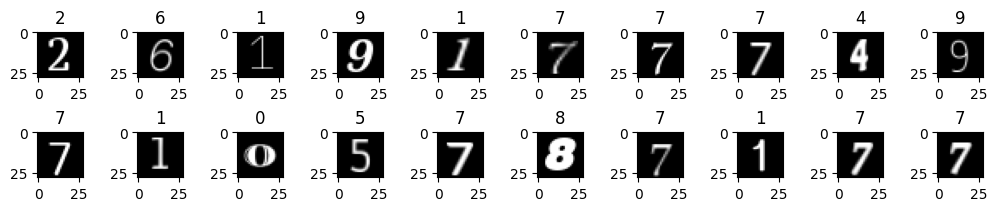

In [4]:
def view(digits, labels, rows=1, cols=10, title=None):
    fig, subs = plt.subplots(rows, cols, layout='constrained', figsize=(cols,rows + (0.25 if title else 0)), squeeze=False)
    if title:
        fig.suptitle(title)
    subs = [s for sub in subs for s in sub] 
    for digit, label, sub in zip(digits, labels, subs):
        sub.set_title(label)
        sub.imshow(digit, cmap='gray')

samples = np.random.choice(len(digits), 20)

view(digits[samples], labels[samples], rows=2)

2024-06-09 21:46:41.115017: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 21:46:41.155704: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 21:46:41.155741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 21:46:41.157812: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 21:46:41.157838: I external/local_xla/xla/stream_executor

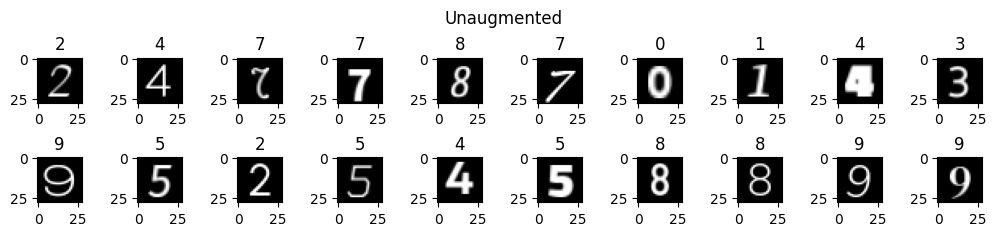

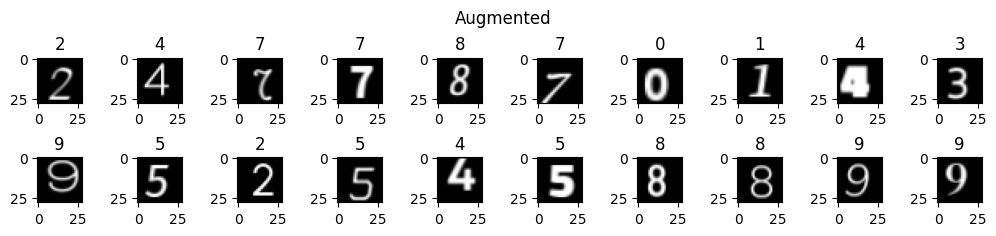

In [5]:
# As with digit recognition, it's only really the translations that are relevant (I add the 90/180/270 deg rotations later)
augmentations = keras.Sequential([
    # layers.RandomRotation(0.05),
    # layers.RandomZoom((-0.2, 0), (-0.2, 0), fill_mode="constant", fill_value=0),
    layers.RandomTranslation((-0.1, 0.1), (-0.1, 0.1), fill_mode="constant", fill_value=0),
])

samples = np.random.choice(len(digits), 20)

augmented_digits = augmentations(digits[samples])

view(digits[samples], labels[samples], title="Unaugmented", rows=2)
view(augmented_digits, labels[samples], title="Augmented", rows=2)

In [6]:
# As a n00b I have no idea how to do this not in memory...
x = np.concatenate([digits] + [augmentations(digits) for _ in range(4)])

p = np.random.permutation(len(x))
x = x[p]

print("Digits after augmentation:", len(x))

Digits after augmentation: 149500


Digits with rotations: 598000


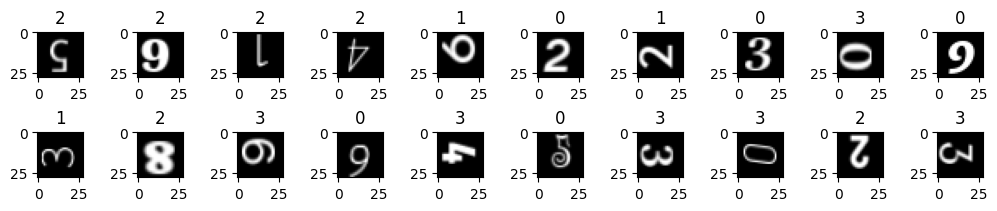

In [7]:
def add_orientations(x):
    length = len(x)
    x = np.concatenate([
        np.array([np.rot90(d, k=i) for d in x])
        for i in range(4)
    ])
    y = np.concatenate([np.full((length,), i) for i in range(4)])

    assert len(x) == len(y)
    
    p = np.random.permutation(len(x))
    return x[p], y[p]

x, y = add_orientations(x)

samples = np.random.choice(len(digits), 20)

print("Digits with rotations:", len(x))
view(x[samples], y[samples], rows=2)

In [8]:
TRAINING_SET = 0.8
r = np.random.default_rng(seed=12345)
training_mask = np.fromiter((r.random() <= TRAINING_SET for _ in range(len(x))), dtype=bool)

x_train = x[training_mask]
x_test = x[~training_mask]

y_train = keras.utils.to_categorical(y[training_mask], 4)
y_test = keras.utils.to_categorical(y[~training_mask], 4)

print("Training samples:", len(x_train))
print("Test samples:", len(x_test))

Training samples: 478524
Test samples: 119476


In [9]:
model = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        # layers.Dropout(0.5),
        # layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)             

In [10]:
# Had 10k before downgrading tensorflow to make tfjs conversions work...
batch_size = 8000
# Something about "early exit" to help optimise the count of epoch?
epochs = 200

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/200


2024-06-09 21:47:12.997676: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-06-09 21:47:15.244917: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f20f5ac3090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-09 21:47:15.244947: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-06-09 21:47:15.277524: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717969635.380077     210 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 [==============================] - 12s 96ms/step - loss: 0.8414 - accuracy: 0.6338 - val_loss: 0.5605 - val_accuracy: 0.7635
Epoch 2/200
54/54 [==============================] - 2s 39ms/step - loss: 0.5375 - accuracy: 0.7671 - val_loss: 0.4434 - val_accuracy: 0.8208
Epoch 3/200
54/54 [==============================] - 2s 39ms/step - loss: 0.4605 - accuracy: 0.8041 - val_loss: 0.3970 - val_accuracy: 0.8385
Epoch 4/200
54/54 [==============================] - 2s 38ms/step - loss: 0.4209 - accuracy: 0.8198 - val_loss: 0.3667 - val_accuracy: 0.8483
Epoch 5/200
54/54 [==============================] - 2s 39ms/step - loss: 0.3965 - accuracy: 0.8285 - val_loss: 0.3483 - val_accuracy: 0.8565
Epoch 6/200
54/54 [==============================] - 2s 39ms/step - loss: 0.3803 - accuracy: 0.8351 - val_loss: 0.3350 - val_accuracy: 0.8606
Epoch 7/200
54/54 [==============================] - 2s 39ms/step - loss: 0.3675 - accuracy: 0.8398 - val_loss: 0.3241 - val_accuracy: 0.8648
Epoch 8/200
54/54

3734/3734 [==============================] - 16s 4ms/step - loss: 0.2061 - accuracy: 0.9028
Test loss: 0.20613516867160797
Test accuracy: 0.9027670621871948


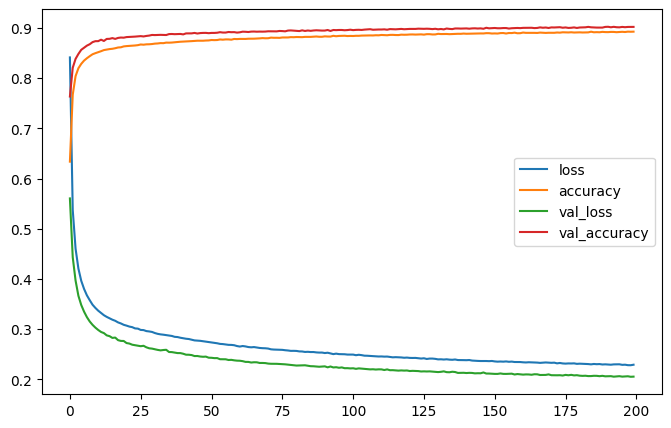

In [11]:
score = model.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [12]:
import time
model.save(f"models/orientations_{int(score[1] * 10000)}_{int(score[0] * 10000):04}_{int(time.time())}.keras")